In [727]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input, MultiHeadAttention, Dropout, Concatenate,LayerNormalization
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [728]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)

In [729]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [730]:
# def create_sequences(data, seq_length):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         sequences.append(data[i:i + seq_length])
#         targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
#     return np.array(sequences), np.array(targets)

In [731]:
sequence_length = 1 # Sử dụng 30 ngày để dự đoán
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

In [732]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [733]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

In [734]:
# LSTM lớp ẩn
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Lớp Attention
attention = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention])
dropout_layer = Dropout(0.1)(concat_output)
# attention_output = tf.reduce_sum(dropout_layer, axis=1)
lstm_out_attention = LSTM(32)(dropout_layer)
# Lớp đầu ra
output = Dense(7)(lstm_out_attention)

In [735]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 1, 7)]               0         []                            
                                                                                                  
 lstm_63 (LSTM)              (None, 1, 64)                18432     ['input_41[0][0]']            
                                                                                                  
 multi_head_attention_43 (M  (None, 1, 64)                66368     ['lstm_63[0][0]',             
 ultiHeadAttention)                                                  'lstm_63[0][0]']             
                                                                                                  
 concatenate_38 (Concatenat  (None, 1, 128)               0         ['lstm_63[0][0]',      

In [736]:
# 3. Huấn luyện mô hình
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 8s 29ms/step - loss: 0.0287 - val_loss: 0.0139
Epoch 2/50
64/64 [==============================] - 1s 10ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 3/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 4/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 5/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 6/50
64/64 [==============================] - 0s 8ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 7/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 8/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 9/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 10/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 11/50
64/6

In [737]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [738]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 2s 11ms/step
R² (R-squared): 0.7868528300891731
Nash-Sutcliffe Efficiency (NSE): 0.8654629249755919
Mean Absolute Error (MAE): 0.04238088619512247
Root Mean Squared Error (RMSE): 0.07479939862186098


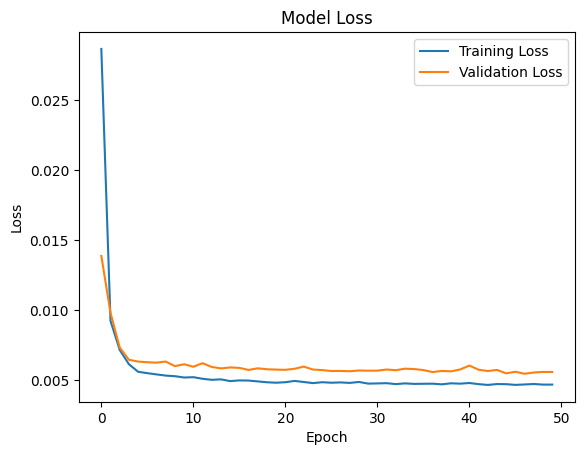

In [739]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [740]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(new_data)

In [741]:
# Chuẩn hóa dữ liệu mới
new_data_scaled = scaler.transform(new_data)  # Sử dụng scaler đã huấn luyện từ dữ liệu ban đầu
X_new,Y_new = [],[]
for i in range(sequence_length, len(new_data_scaled)):
    X_new.append(new_data_scaled[i-sequence_length:i])
    Y_new.append(new_data_scaled[i])
X_new = np.array(X_new)
print(len(X_new))
y_new = np.array(Y_new)

737


In [742]:
dates = new_data.columns
print(dates)

Index(['mucNuocHN', 'nuocVeHoaBinh', 'chayMayHoaBinh', 'nuocVeTuyenQuang',
       'chayMayTuyenQuan', 'nuocVeThacBa', 'chayMayThacBa'],
      dtype='object')


In [743]:
predictions = model.predict(X_new)
predictions_new_original = scaler.inverse_transform(predictions)[:,0]
y_test_new_original = scaler.inverse_transform(y_new)[:,0]

24/24 [==============================] - 3s 5ms/step


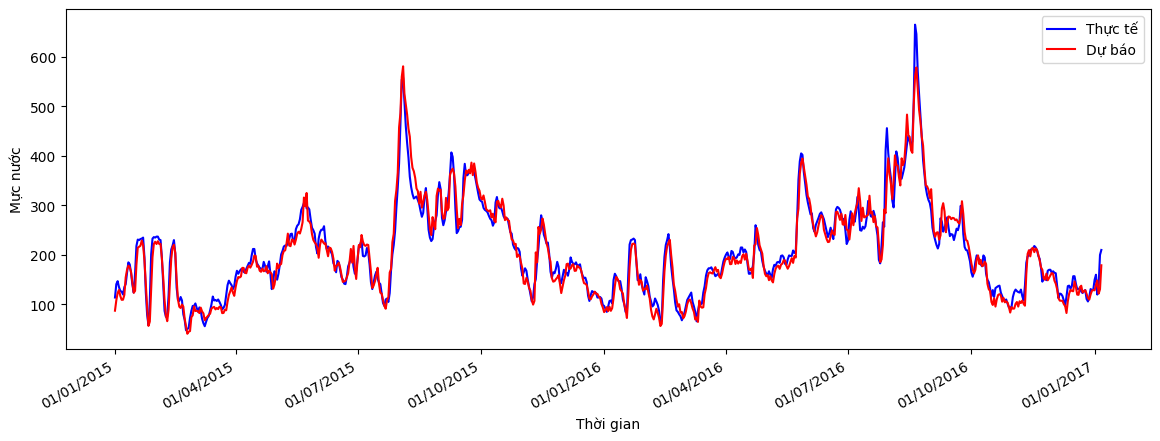

In [744]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [745]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = new_data.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]

# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})

# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-02        114.0   87.371582
2015-01-03        141.0  108.278618
2015-01-04        147.0  123.189034
2015-01-05        135.0  129.191635
2015-01-06        127.0  116.865196
...                 ...         ...
2017-01-03        160.0  139.635712
2017-01-04        120.0  148.390732
2017-01-05        140.0  121.865112
2017-01-06        200.0  130.559753
2017-01-07        210.0  179.093781

[737 rows x 2 columns]
